In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, jarque_bera, shapiro, ttest_1samp, chi2
from statsmodels.stats.diagnostic import acorr_ljungbox,het_arch, het_white
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import genextreme as gev
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['savefig.facecolor']='white'

In [2]:
def normality(data):
    mu = np.mean(data)
    sigma = np.std(data)

    print("Test Kołmogorowa-Smirnowa: {}.".format(kstest((data-mu)/sigma, 'norm').pvalue))
    print("Test Jarque-Bera: {}.".format(jarque_bera(data).pvalue))
    print("Test Shapiro-Wilka: {}.".format(shapiro(data).pvalue))

    fig, axes = plt.subplots(1, 3, figsize=(20,6))

    x = np.arange(min(data), max(data)+1)
    axes[0].hist(data, bins=20, color='deeppink', alpha=0.6, density=True, label="Histogram prawdopodobieństwa danych")
    axes[0].plot(x, stats.norm.pdf(x, mu, sigma), color='indigo', label="Gęstość teoretyczna")
    axes[0].set_title('Porównanie gęstości')
    axes[0].legend(loc="best")

    ecdf = ECDF(data)
    axes[1].set_title('Porównanie dystrybuant')
    axes[1].plot(x, ecdf(x), color='deeppink', label='Dystrybuanta empiryczna')
    axes[1].plot(x, stats.norm.cdf(x, mu, sigma), color="indigo", linestyle='--', label="Dystrybuanta teoretyczna")
    axes[1].legend(loc="best")

    bplot = axes[2].boxplot(data, patch_artist=True, medianprops=dict(color="deeppink"))
    bplot['boxes'][0].set_facecolor('white')
    axes[2].grid(False)
    axes[2].set_title("Boxplot danych")

    plt.show()

# 1. Przygotowanie danych

In [3]:
cocoa = pd.read_csv('Cocoa.csv')
milk = pd.read_csv('Milk.csv')
sugar = pd.read_csv('Sugar.csv')

In [4]:
cocoa['Date'] = pd.to_datetime(cocoa['Date'])
milk['Date'] = pd.to_datetime(milk['Date'])
sugar['Date'] = pd.to_datetime(sugar['Date'])

In [5]:
cocoa['Close/Last'] = cocoa['Close/Last'].astype(float)
milk['Close/Last'] = milk['Close/Last'].astype(float)
sugar['Close/Last'] = sugar['Close/Last'].astype(float)

In [6]:
pln_usd = pd.read_csv("PLNUSD=X.csv")

In [7]:
pln_usd = pln_usd[pln_usd["Close"].notnull()]

In [8]:
pln_usd.reset_index(inplace=True)

In [9]:
pln_usd["Date"] = pd.to_datetime(pln_usd["Date"])

In [10]:
dates = []
for i in range(len(pln_usd)):
    if pln_usd["Date"][i] not in list(cocoa["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(milk["Date"]):
        dates.append(pln_usd["Date"][i])
    if pln_usd["Date"][i] not in list(sugar["Date"]):
        dates.append(pln_usd["Date"][i])

In [11]:
for i in range(len(cocoa)):
    if cocoa["Date"][i] not in list(pln_usd["Date"]):
        dates.append(cocoa["Date"][i])
    if sugar["Date"][i] not in list(pln_usd["Date"]):
        dates.append(sugar["Date"][i])

In [12]:
for i in range(len(milk)):
    if milk["Date"][i] not in list(pln_usd["Date"]):
        dates.append(milk["Date"][i])

In [13]:
dates = list(set(dates))

In [14]:
for i in range(len(dates)):
    pln_usd = pln_usd[pln_usd["Date"] !=  dates[i]]
    cocoa = cocoa[cocoa["Date"] !=  dates[i]]
    milk = milk[milk["Date"] !=  dates[i]]
    sugar = sugar[sugar["Date"] !=  dates[i]]

In [15]:
pln_usd = pln_usd[::-1]

In [16]:
pln_usd.reset_index(inplace=True)
cocoa.reset_index(inplace=True)
milk.reset_index(inplace=True)
sugar.reset_index(inplace=True)

Zamiana danych na stopy procentowe.

In [17]:
T = 1/252
cocoa_close = np.array([round((cocoa['Close/Last'][i] - cocoa['Close/Last'][i+1])/(cocoa['Close/Last'][i+1] * T),3) for i in range(len(cocoa)-1)])
milk_close = np.array([round((milk['Close/Last'][i] - milk['Close/Last'][i+1])/(milk['Close/Last'][i+1] * T), 3) for i in range(len(milk)-1)])
sugar_close = np.array([round((sugar['Close/Last'][i] - sugar['Close/Last'][i+1])/(sugar['Close/Last'][i+1] * T), 3) for i in range(len(sugar)-1)])
pln_usd_close = np.array([round((pln_usd['Close'][i] - pln_usd['Close'][i+1])/(pln_usd['Close'][i+1] * T), 3) for i in range(len(pln_usd)-1)])

In [18]:
cocoa_close /= 100
milk_close /= 100
sugar_close /= 100
pln_usd_close /= 100

In [19]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)
print(mu_c, sigma_c)

mu_m = np.mean(milk_close)
sigma_m = np.std(milk_close)
print(mu_m, sigma_m)

mu_s = np.mean(sugar_close)
sigma_s = np.std(sugar_close)
print(mu_s, sigma_s)

0.0011226437699680513 0.046895540026747284
0.0017608067092651758 0.06315052203248535
0.0007991214057507985 0.0481337056540928


In [20]:
n = len(cocoa_close)
C = cocoa_close.reshape(1,n)
M = milk_close.reshape(1,n)
S = sugar_close.reshape(1,n)
R = np.concatenate([C,M,S],axis=0)
print(R)

[[-0.03694 -0.00097  0.0127  ... -0.00941  0.0313   0.04996]
 [-0.00205  0.0417  -0.02171 ... -0.00497  0.00166  0.     ]
 [-0.0799   0.03211 -0.01532 ... -0.03277 -0.1246  -0.00931]]


$R_p = 0.4\cdot R_c + 0.22\cdot R_s + 0.38\cdot R_m$

In [21]:
Rp = 0.5 * cocoa_close + 0.2 * milk_close + 0.3 * sugar_close

In [22]:
w = np.array([0.5, 0.2, 0.3])
print("Stopa zwrotu porfela: {}, ryzyko portfela: {}.".format(w[0]*mu_c + w[1]*mu_m + w[2]*mu_s, np.sqrt(np.dot(w.T, np.dot(np.cov(R), w)))))

Stopa zwrotu porfela: 0.0011532196485623003, ryzyko portfela: 0.03151053404357198.


# 2. Wartość zagrożna (dla zmiennej kakao)

## a) metoda parametryczna

In [23]:
L = cocoa_close[cocoa_close > 0] #dodatnie stopy zwrotu są dla nas stratą

In [24]:
cocoa_close *= 100

Test Kołmogorowa-Smirnowa: 0.5032361558324656.
Test Jarque-Bera: 0.0.
Test Shapiro-Wilka: 2.2554233964910964e-06.


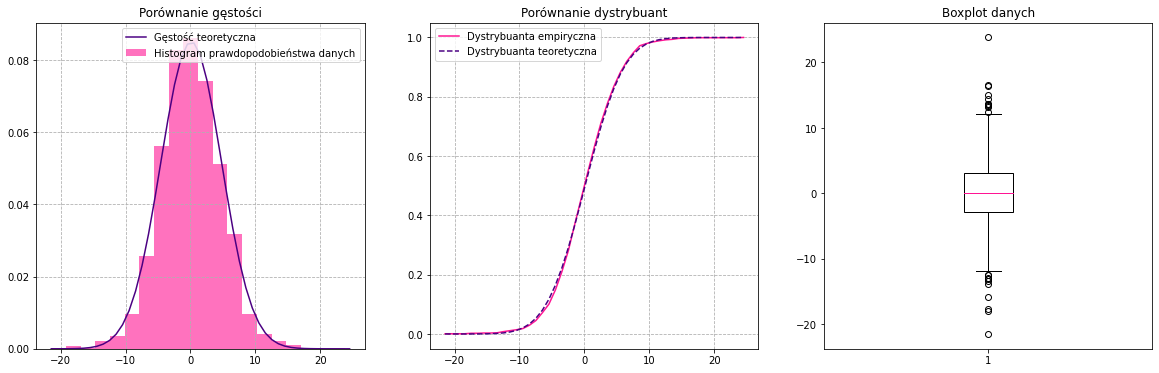

In [25]:
normality(cocoa_close)

Do danych dobieramy odpowiedni rozkład. W naszym przypadku jest to rozkład GEV.

In [26]:
L *= 100

In [27]:
pd.DataFrame(L,columns=['lost']).to_csv('kakao_straty.csv')

In [28]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)
stats.norm.ppf(0.95, mu_c, sigma_c)

7.825894287081127

In [29]:
stats.norm.ppf(0.99,mu_c,sigma_c)

11.021798361318876

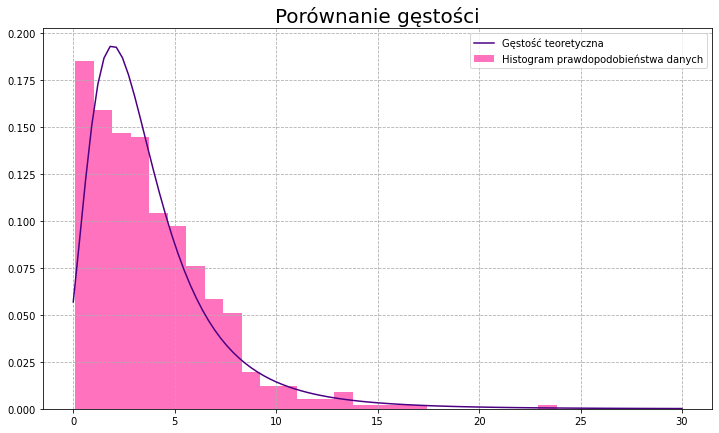

In [30]:
t = np.linspace(0,30,100)
plt.hist(L, density=True, bins="auto", label="Histogram prawdopodobieństwa danych", color='deeppink', alpha=0.6)
fit = gev.fit(L)
pdf = gev.pdf(t, *fit)
plt.plot(t, pdf, label="Gęstość teoretyczna", color='indigo')
plt.title("Porównanie gęstości", fontsize=20)
plt.legend()
#plt.savefig("gev_dens")
plt.show()

In [31]:
print("parametry rozkładu: ", fit) #shape, location, scale

parametry rozkładu:  (-0.19152298704289422, 2.2761829962389952, 1.9335613214305636)


In [32]:
ksi = fit[0]
mu = fit[1]
sigma = fit[2]

$VaR_{95\%}$

In [33]:
mu - (sigma/ksi)*(1-(-np.log(0.95))**(-ksi))

6.6560053521224525

$VaR_{99\%}$

In [34]:
mu - (sigma/ksi)*(1-(-np.log(0.99))**(-ksi))

8.18869641807082

## b) metoda historyczna

### zwykła

In [35]:
np.quantile(L, 0.95) #punkt, poniżej którego jest 5% obserwacji

8.951999999999995

In [36]:
np.quantile(L, 0.99)

13.597829999999997

### ważona

In [37]:
lamb1 = 0.95
lamb2 = 0.99
n = len(L)

In [38]:
w1 = 1/(1+np.sum([lamb1**(i-1) for i in range(2,n+1)]))

In [39]:
weights = [w1*lamb1**(i-1) for i in range(1,n+1)]

In [40]:
sorted_L = sorted(list(zip(L, weights)), key=lambda x: x[0])

In [41]:
sorted_Lprob = [[sorted_L[i][0], sum(sorted_L[j][1] for j in range(0, i+1))] for i in range(0, n)]

In [42]:
for i in range(n):
    if sorted_Lprob[i][1] >= 0.95:
        q95 = sorted_Lprob[i][0]
        break

In [43]:
q95

9.366

In [44]:
#szukamy takiego elementu listy (druga wartość - waga), żeby był on w przybliżeniu równy alpha
diff = [abs(sorted_Lprob[i][1]-lamb1) for i in range(0, n)]
ind = diff.index(min(diff))
print(sorted_Lprob[ind]) #wartość VaR to pierwszy element z listy

[9.366, 0.9698488435469452]


$VaR_{95\%} = 0.06497$

In [45]:
w1_lamb2 = 1/(1+np.sum([lamb2**(i-1) for i in range(2, n+1)]))

In [46]:
weights_lamb2 = [w1_lamb2*lamb2**(i-1) for i in range(1, n+1)]

In [47]:
sortedL_lamb2= sorted(list(zip(L, weights_lamb2)), key=lambda x: x[0])

In [48]:
sortedL_prob_lamb2 = [[sortedL_lamb2[i][0], sum(sortedL_lamb2[j][1] for j in range(0, i+1))] for i in range(0, n)]

In [49]:
for i in range(n):
    if sortedL_prob_lamb2[i][1] >= 0.99:
        q99 = sortedL_prob_lamb2[i][0]
        break

In [50]:
#szukamy takiego elementu listy (druga wartość - waga), żeby był on w przybliżeniu równy alpha
diff2 = [abs(sortedL_prob_lamb2[i][1]-lamb2) for i in range(0, n)]
ind2 = diff2.index(min(diff2))
print(sortedL_prob_lamb2[ind2]) #wartość VaR to pierwszy element z listy

[14.996, 0.9873495152197914]


In [51]:
q99

16.393

$VaR_{99\%} = 0.13654$

### przy użyciu filtrowania szeregiem GARCH

Zrobione w pliku Garch.R

## c) metoda Monte Carlo

In [52]:
#dobieramy model regresji liniowej dla zmiennej kakao opisanej czynnikiem ryzyka
y1 = cocoa_close[:1251]
x1 = pln_usd_close[0:1251]
x1 = sm.add_constant(x1)
model1 = sm.GLS(y1, x1).fit()

print(model1.summary())

alpha1 = model1.params[0]
beta1 = model1.params[1]
print(alpha1, beta1)



                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            GLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.268
Date:                Thu, 02 Jun 2022   Prob (F-statistic):              0.132
Time:                        14:08:39   Log-Likelihood:                -3707.1
No. Observations:                1251   AIC:                             7418.
Df Residuals:                    1249   BIC:                             7429.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1100      0.133      0.830      0.4

In [53]:
residuals = model1.resid
#sigma_resid = np.var(residuals)
#mu_resid = np.mean(residuals)

In [54]:
train = pln_usd_close[:1251]
test = pln_usd_close[-1]

In [55]:
x = test + residuals
np.quantile(x,0.95),np.quantile(x,0.99)

(7.545095597360221, 11.790429958459036)

# 3. Testowanie wsteczne dla każdego z podpunktów.

### Test pokrycia (Kupca)

In [82]:
# metoda parametryczna - gev
def var_parametric(data, alpha):
    fit = gev.fit(data)
    ksi = fit[0]
    mu = fit[1]
    sigma = fit[2]

    VaR = mu - (sigma/ksi)*(1-(-np.log(alpha))**(-ksi))
    return VaR

In [83]:
# metoda historyczna: VaR == kwantyl empiryczny
def var_hist(data, alpha):
    VaR = np.quantile(data, alpha)
    return VaR

In [84]:
# metoda historyczna ważona
def var_hist_waged(data, alpha):
    data = np.flip(data)
    n = len(data)
    lamb = 0.95

    w1 = 1/(1+np.sum([lamb**(i-1) for i in range(2,n+1)]))
    weights = [w1*lamb**(i-1) for i in range(1,n+1)]

    sorted_L = sorted(list(zip(data, weights)), key=lambda x: x[0])
    sorted_Lprob = [[sorted_L[i][0], sum(sorted_L[j][1] for j in range(0, i+1))] for i in range(0, n)]
    
    for i in range(n):
        if sorted_Lprob[i][1] >= alpha:
            VaR = sorted_Lprob[i][0]
            break

    return VaR

In [88]:
def coverage_test(data, alpha, var_type="var_hist"):
    n = len(data)
    train = data[:int(n/2)]
    test = data[int(n/2):]

    train_copy = train

    I = []
    for i in range(len(test)):
        VaR = eval(var_type)(train_copy, alpha)
        if test[i] < VaR:
            I.append(1)
        else:
            I.append(0)

        train_copy = np.delete(train_copy,0)
        train_copy = np.append(train_copy,test[i])

    p = alpha

    I = np.array(I)
    I_0 = np.count_nonzero(I==0)
    I_1 = np.count_nonzero(I==1)
    pi = np.mean(I)
    
    L_pi = (1-pi)**I_0 * pi**I_1
    L_p = (1-p)**I_0 * p**I_1
    LR = -2 * np.log(L_p/L_pi)

    pvalue = 1 - chi2.cdf(LR, 1)

    return pvalue

In [90]:
coverage_test(np.flip(L), 0.95, "var_parametric")

1.0960767607204325e-05

In [99]:
coverage_test(np.flip(L), 0.99, "var_parametric")

7.31877225490507e-10

In [89]:
coverage_test(np.flip(L), 0.95, "var_hist")

0.8968476121942868

In [97]:
coverage_test(np.flip(L), 0.99, "var_hist")

0.3192186461155102

In [91]:
coverage_test(np.flip(L), 0.95, "var_hist_waged")

0.3775935481321544

In [98]:
coverage_test(np.flip(L), 0.99, "var_hist_waged")

0.05597221395983787

### Test niezależności

In [92]:
def independence_test(data, alpha, var_type="var_hist"):
    n = len(data)
    train = data[:int(n/2)]
    test = data[int(n/2):]

    train_copy = train

    I = []
    for i in range(len(test)):
        VaR = eval(var_type)(train_copy, alpha)
        if test[i] < VaR:
            I.append(1)
        else:
            I.append(0)

        train_copy = np.delete(train_copy,0)
        train_copy = np.append(train_copy,test[i])

    I = np.array(I)
    pi = np.mean(I)

    I_00 = 0
    I_01 = 0
    I_10 = 0
    I_11 = 0

    pairs = [(I[i],I[i+1]) for i in range(len(I)-1)]

    for i in range(len(pairs)):
        if pairs[i] == (0, 0):
            I_00 += 1
        if pairs[i] == (0, 1):
            I_01 += 1
        if pairs[i] == (1, 0):
            I_10 += 1
        if pairs[i] == (1, 1):
            I_11 += 1

    L_pi = (1 - I_01/(I_00+I_01))**(I_00) * (I_01/(I_00+I_01))**(I_01) * (1 - I_11/(I_10+I_11))**I_10 * (I_11/(I_10+I_11))**I_11
    L_PI = (1-pi)**(I_00) * (pi)**(I_01) * (1 - pi)**I_10 * (pi)**I_11

    LR = -2*np.log(L_PI/L_pi)
    pvalue = 1 - chi2.cdf(LR,1)

    return pvalue

In [95]:
independence_test(np.flip(L), 0.95, "var_parametric")

0.5972385265642555

In [100]:
independence_test(np.flip(L), 0.99, "var_parametric")

0.8648303728556412

In [96]:
independence_test(np.flip(L), 0.95, "var_hist")

0.8465307807219629

In [101]:
independence_test(np.flip(L), 0.99, "var_hist")

0.6850159313954863

In [94]:
independence_test(np.flip(L), 0.95, "var_hist_waged")

0.8648303728556412

In [102]:
independence_test(np.flip(L), 0.99, "var_hist_waged")

0.5688520359330581